## Plot Simulation

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [122]:
def draw_latency(data_path, label:str, xunits: list[float], xlabels: list[str], ymax: int):

    plt.figure(figsize=(7, 3))
    df = pd.read_csv(data_path, header=None)

    way = df[0][0]
    assoc = df[1][0]
    latencies = df[2] / 1e6
    improvements = (df[4] - df[5]) / df[4] * 100
    plt.plot(latencies, improvements, label='LRU-MAD')

    plt.xscale('log')
    plt.xticks(xunits, xlabels)
    plt.xlim(xunits[0] / 1.5, xunits[-1] * 1.5)
    plt.ylim(0, ymax)
    plt.xlabel('Latency')
    plt.ylabel('\% Latency Improvement')
    plt.legend()
    plt.title(f"{label}: {way}-way {assoc}-associative")
    # use down-triangle marker for all points
    plt.scatter(latencies, improvements, marker='v')
    plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

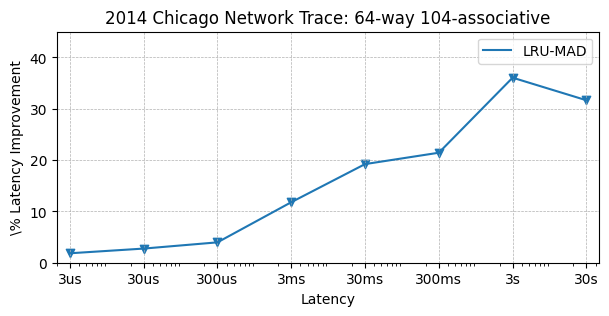

In [123]:
# 2014 chicago, latency from 3us to 30s, ylim 45
draw_latency('results/2014chicago.csv', '2014 Chicago Network Trace', [3e-3, 3e-2, 3e-1, 3, 3e1, 3e2, 3e3, 3e4], ['3us', '30us', '300us', '3ms', '30ms', '300ms', '3s', '30s'], 45)
plt.show()

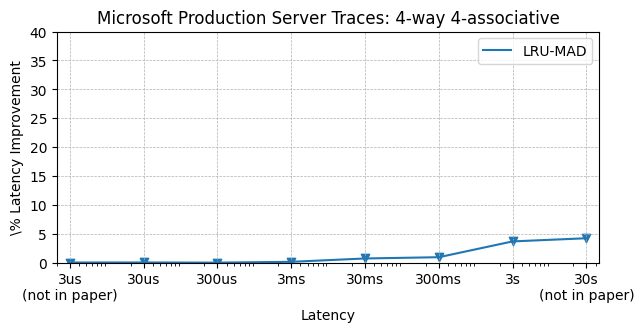

In [124]:
# storage trace, latency from 30us to 3s, ylim 40
draw_latency('results/storage.csv', 'Microsoft Production Server Traces', [3e-3, 3e-2, 3e-1, 3, 3e1, 3e2, 3e3, 3e4], ['3us\n(not in paper)','30us', '300us', '3ms', '30ms', '300ms', '3s', '30s\n(not in paper)'], 40)

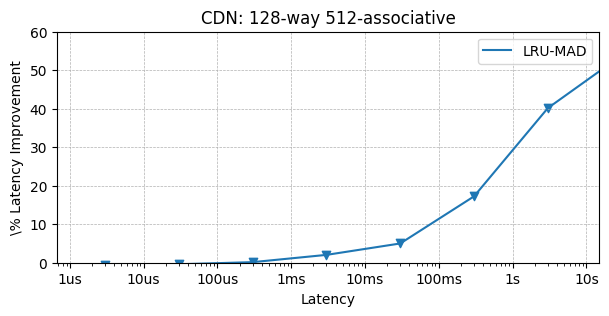

In [125]:
# cdn, latency from 1us to 10s, ylim 60
draw_latency('results/cdn.csv', 'CDN', [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4], ['1us', '10us', '100us', '1ms', '10ms', '100ms', '1s', '10s'], 60)

## CDN Experiment

In [115]:
from dataclasses import dataclass
@dataclass
class CDNResult:
    lru_mean: float # in ms
    lru_std: float # in ms
    mad_mean: float # in ms
    mad_std: float # in ms
    
    def improvement(self):
        return (self.lru_mean - self.mad_mean) / self.lru_mean * 100

In [116]:
def parse_result(path: str) -> CDNResult:
    data = pd.read_csv(path)
    return CDNResult(data['LRU'].mean() / 1e3,
                      data['LRU'].std() / 1e3,
                        data['LRU-MAD'].mean() / 1e3,
                          data['LRU-MAD'].std() / 1e3)

In [117]:
experiment_paper = CDNResult(19.13, 0.37, 16.32, 0.01)
experiment_0529 = parse_result('./results/tokyo_wheat17_0529.csv')
experiment_0604 = parse_result('./results/tokyo_wheat17_0604.csv')

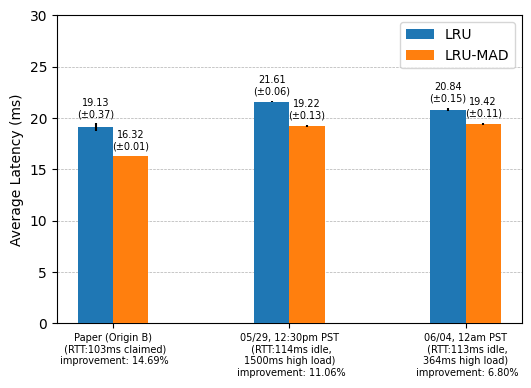

In [121]:
bar_width = 0.2
# 3 groups with 2 bars each

fig, ax = plt.subplots(figsize=(6, 4))
x = np.arange(3)

lru_means = [experiment_paper.lru_mean, experiment_0529.lru_mean, experiment_0604.lru_mean]
lru_stds = [experiment_paper.lru_std, experiment_0529.lru_std, experiment_0604.lru_std]
mad_means = [experiment_paper.mad_mean, experiment_0529.mad_mean, experiment_0604.mad_mean]
mad_stds = [experiment_paper.mad_std, experiment_0529.mad_std, experiment_0604.mad_std]

rect = ax.bar(x - bar_width/2, lru_means, bar_width, yerr=lru_stds, label='LRU', zorder=3)
ax.bar_label(rect, padding=3, labels=[f'{mean:.2f}\n(±{std:.2f})' for mean, std in zip(lru_means, lru_stds)],fontsize=7)
rect = ax.bar(x + bar_width/2, mad_means, bar_width, yerr=mad_stds, label='LRU-MAD', zorder=3)
ax.bar_label(rect, padding=3, labels=[f'{mean:.2f}\n(±{std:.2f})' for mean, std in zip(mad_means, mad_stds)],fontsize=7)

ax.set_xticks(x, [f'Paper (Origin B)\n (RTT:103ms claimed)\n improvement: {experiment_paper.improvement():.2f}%',
                   f'05/29, 12:30pm PST\n (RTT:114ms idle,\n1500ms high load)\n improvement: {experiment_0529.improvement():.2f}%',
                     f'06/04, 12am PST\n (RTT:113ms idle,\n364ms high load)\n improvement: {experiment_0604.improvement():.2f}%'], fontsize=7)
ax.set_ylim(0, 30)
ax.set_ylabel('Average Latency (ms)')
ax.legend()
ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)



In [80]:
lru_means

[19.13, 21608.210000000003, 20838.303999999996]

## CDF for CDN experiment

At date 06/04

In [179]:
request_starts_lru = np.load("./results/tokyo_wheat17_0604/request_starts_lru.npy")
request_starts_mad = np.load("./results/tokyo_wheat17_0604/request_starts_lru-mad.npy")
request_ends_lru = np.load("./results/tokyo_wheat17_0604/request_ends_lru.npy")
request_ends_mad = np.load("./results/tokyo_wheat17_0604/request_ends_lru-mad.npy")
# sometimes request_ends timestamp is before request_starts timestamp a little bit. We change it to be the same as request_starts
request_ends_lru = np.maximum(request_ends_lru, request_starts_lru)
request_ends_mad = np.maximum(request_ends_mad, request_starts_mad)

latencies_lru = request_ends_lru - request_starts_lru
latencies_mad = request_ends_mad - request_starts_mad

In [180]:
# remove hit case and edge case
latencies_lru_nh = latencies_lru[(latencies_lru > 5e7) & (latencies_lru < 3e8)] 
latencies_mad_nh = latencies_mad[(latencies_mad > 5e7) & (latencies_mad < 3e8)]

In [181]:
miss_rate_lru = np.sum(latencies_lru > 5e7) / len(latencies_lru)
miss_rate_mad = np.sum(latencies_mad > 5e7) / len(latencies_mad)

Text(0.5, 1.0, 'CDF of Request Latency for missed and delay-hit requests')

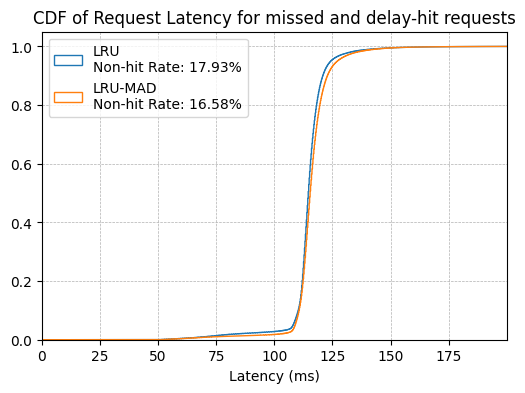

In [188]:
plt.figure(figsize=(6, 4))
bins = np.linspace(0, 201, 1001)
bins[-1] = 10000
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)
plt.hist(latencies_lru_nh / 1e6, density=True, cumulative=True, label=f'LRU\nNon-hit Rate: {miss_rate_lru*100:.2f}%',
          histtype='step', bins=bins)
plt.hist(latencies_mad_nh / 1e6, density=True, cumulative=True, label=f'LRU-MAD\nNon-hit Rate: {miss_rate_mad*100:.2f}%',
          histtype='step', bins=bins)
plt.xlim(0, 199.9)
plt.legend()
plt.xlabel('Latency (ms)')
plt.title('CDF of Request Latency for missed and delay-hit requests')
